In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sqlalchemy import create_engine
import funciones as fx
from pandas import ExcelWriter
from matplotlib import pyplot as plt
import seaborn as sns
import missingno as msngo

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score, confusion_matrix

sns.set(rc = {'figure.figsize':(20,12)})

In [3]:
conn = fx.conexion_sqlalchemy()

In [4]:
df_train = fx.selectViewTrain(conn)
df_test = fx.selectViewTest(conn)

In [5]:
#gonzalo

df_complete = fx.selectViewComplete(conn)

In [6]:
df_test.head()

,Id,Vin,Year,Price,Mileage,City,City_Id,State,State_Id,Make,...,Model_Id,Doors,Fuel_Type,Fuel_Id,Engine_Displacement_CC,Engine_Displacement_CI,Engine_Number_Cylinders,Transmission_Speeds,Gama,Gama_Id
0,1,19VDE2E53EE000083,2014,8995,35725,El Paso,8307,TX,51,Acura,...,1227,4,gasoline,6,2354.000000,144.0,4,6,generalista,1
1,2,19VDE2E52DE000025,2013,8995,48851,El Paso,8307,TX,51,Acura,...,1227,4,gasoline,6,2354.000000,144.0,4,6,generalista,1
2,3,JH4CU2F84EC002686,2014,14490,34032,Greatneck,8550,NY,41,Acura,...,2397,4,gasoline,6,2359.737216,144.0,4,5,generalista,1
3,4,JH4CU2F44CC003220,2012,12921,58550,Boise,7867,ID,19,Acura,...,2394,4,gasoline,6,2359.737216,144.0,4,5,generalista,1
4,5,19VDE1F31EE009243,2014,14995,23454,Hackettstown,8583,NJ,38,Acura,...,1226,4,gasoline,6,1997.000000,121.9,4,5,generalista,1


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206042 entries, 0 to 206041
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Id                       206042 non-null  int64  
 1   Vin                      206042 non-null  object 
 2   Year                     206042 non-null  int64  
 3   Price                    206042 non-null  int64  
 4   Mileage                  206042 non-null  int64  
 5   City                     206042 non-null  object 
 6   City_Id                  206042 non-null  int64  
 7   State                    206042 non-null  object 
 8   State_Id                 206042 non-null  int64  
 9   Make                     206042 non-null  object 
 10  Make_Id                  206042 non-null  int64  
 11  Model                    206042 non-null  object 
 12  Model_Id                 206042 non-null  int64  
 13  Doors                    206042 non-null  int64  
 14  Fuel

In [8]:
#dividir dataset segun gama('generalista, premium, super-premium')

df_test_generalista = df_test[df_test.Gama == 'generalista']
df_test_generalista = df_test_generalista.select_dtypes(include='number')

df_test_premium1 = df_test[df_test.Gama == 'premium_1']
df_test_premium1 = df_test_premium1.select_dtypes(include='number')

df_test_premium2 = df_test[df_test.Gama == 'premium_2']
df_test_premium2 = df_test_premium2.select_dtypes(include='number')

df_test_premium3 = df_test[df_test.Gama == 'premium_3']
df_test_premium3 = df_test_premium3.select_dtypes(include='number')

df_test_premium4 = df_test[df_test.Gama == 'premium_4']
df_test_premium4 = df_test_premium4.select_dtypes(include='number')

df_test_premium5 = df_test[df_test.Gama == 'premium_5']
df_test_premium5 = df_test_premium5.select_dtypes(include='number')

df_test_premium6 = df_test[df_test.Gama == 'premium_6']
df_test_premium6 = df_test_premium6.select_dtypes(include='number')

df_test_premium7 = df_test[df_test.Gama == 'premium_7']
df_test_premium7 = df_test_premium7.select_dtypes(include='number')

df_test_premium8 = df_test[df_test.Gama == 'premium_8']
df_test_premium8 = df_test_premium8.select_dtypes(include='number')


<AxesSubplot:xlabel='Price', ylabel='Make'>

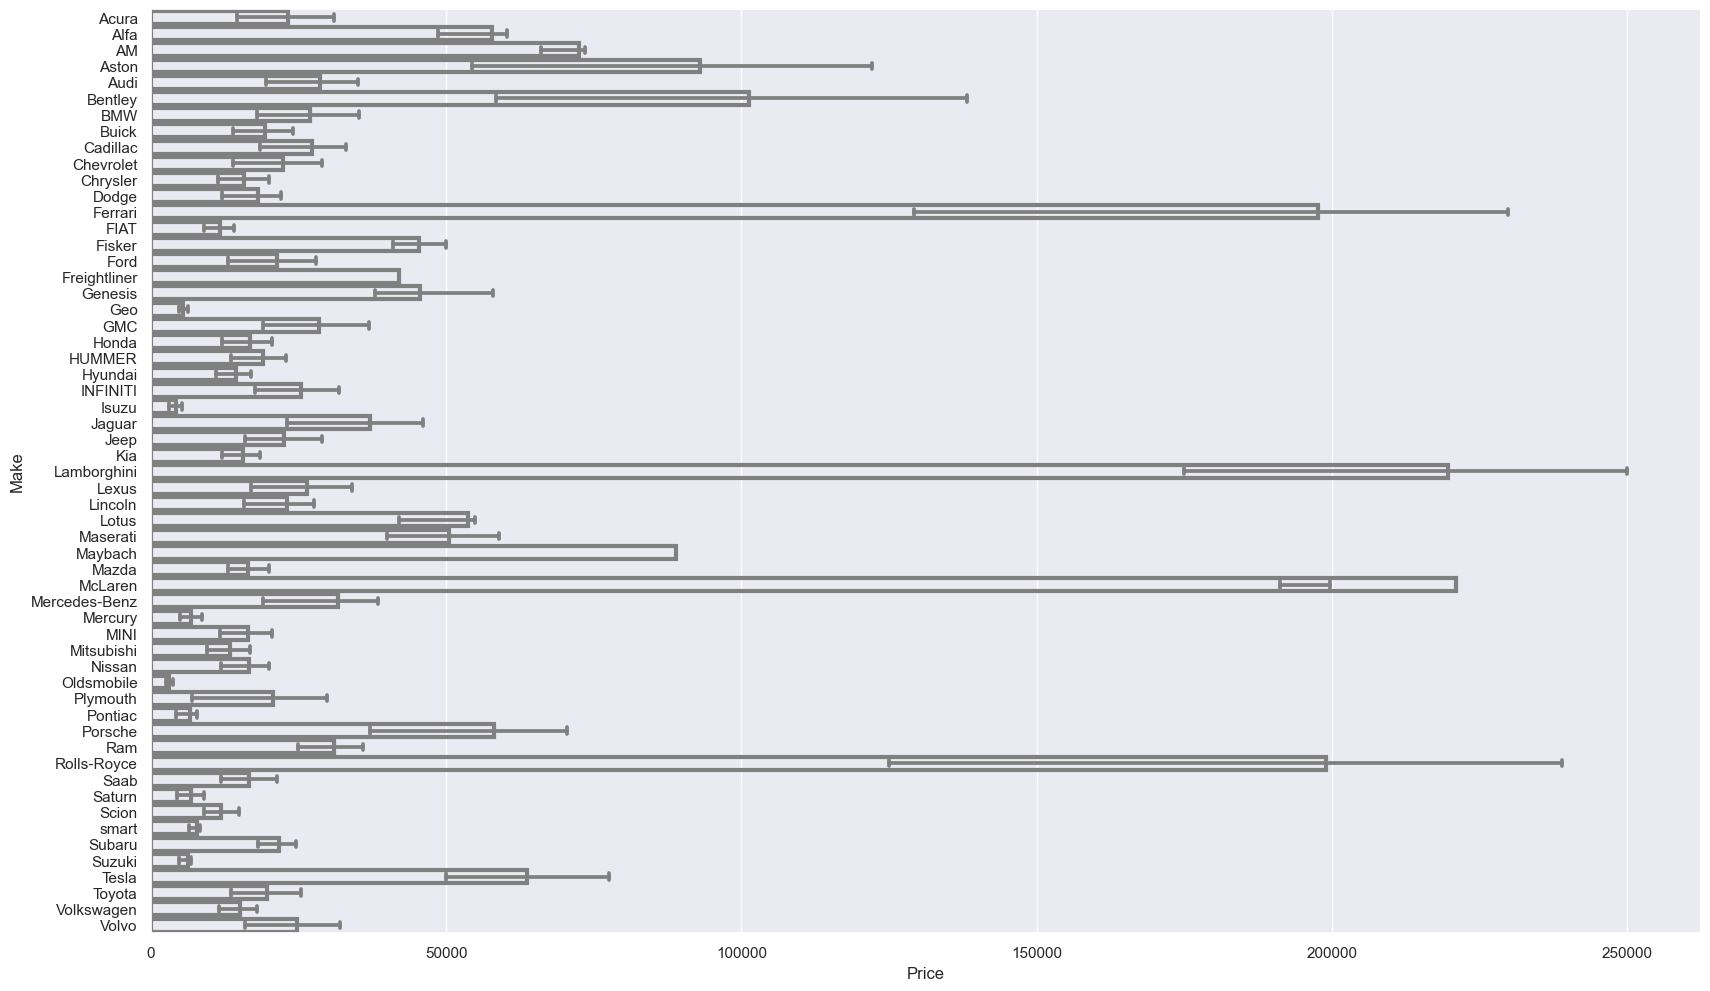

In [9]:
X = df_test.Price
Y = df_test.Make
sns.barplot(
    data=df_test, x=X, y=Y,
    errorbar=("pi", 50), capsize=.4, errcolor=".5",
    linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
)

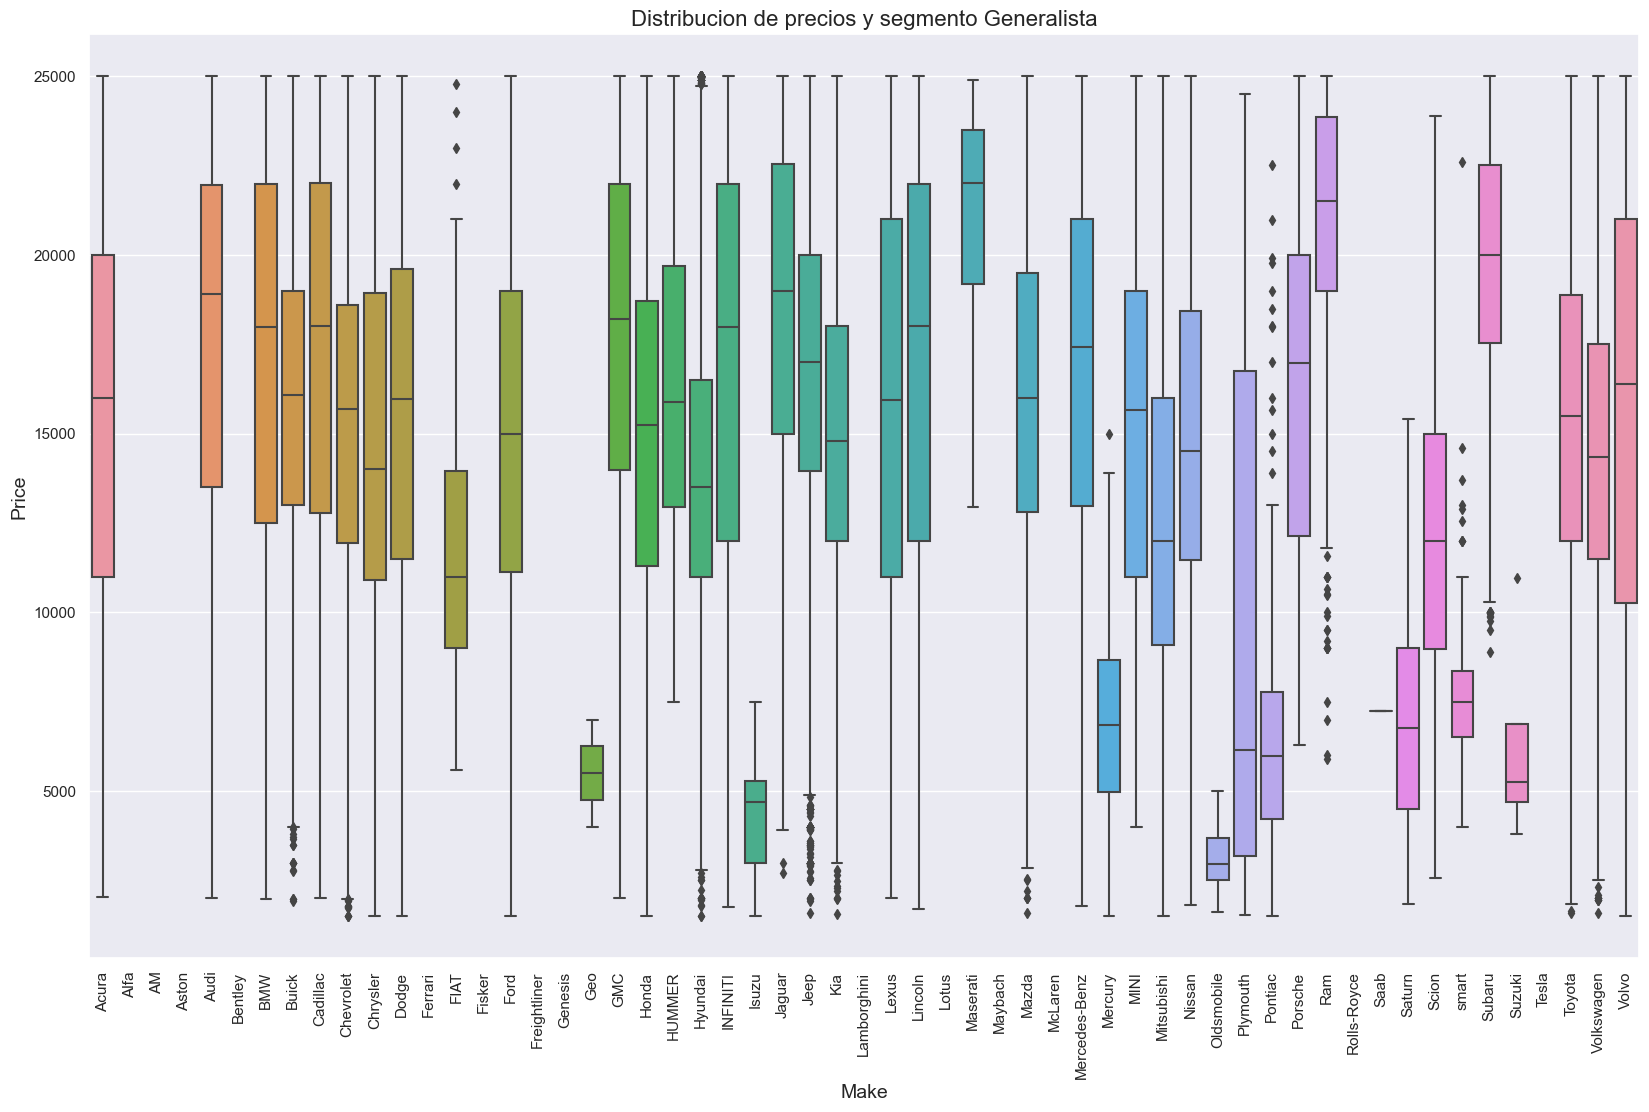

In [38]:
fx.boxplot_graph(df_test['Make'], df_test_generalista['Price'], 'Distribucion de precios y Segmento Generalista')

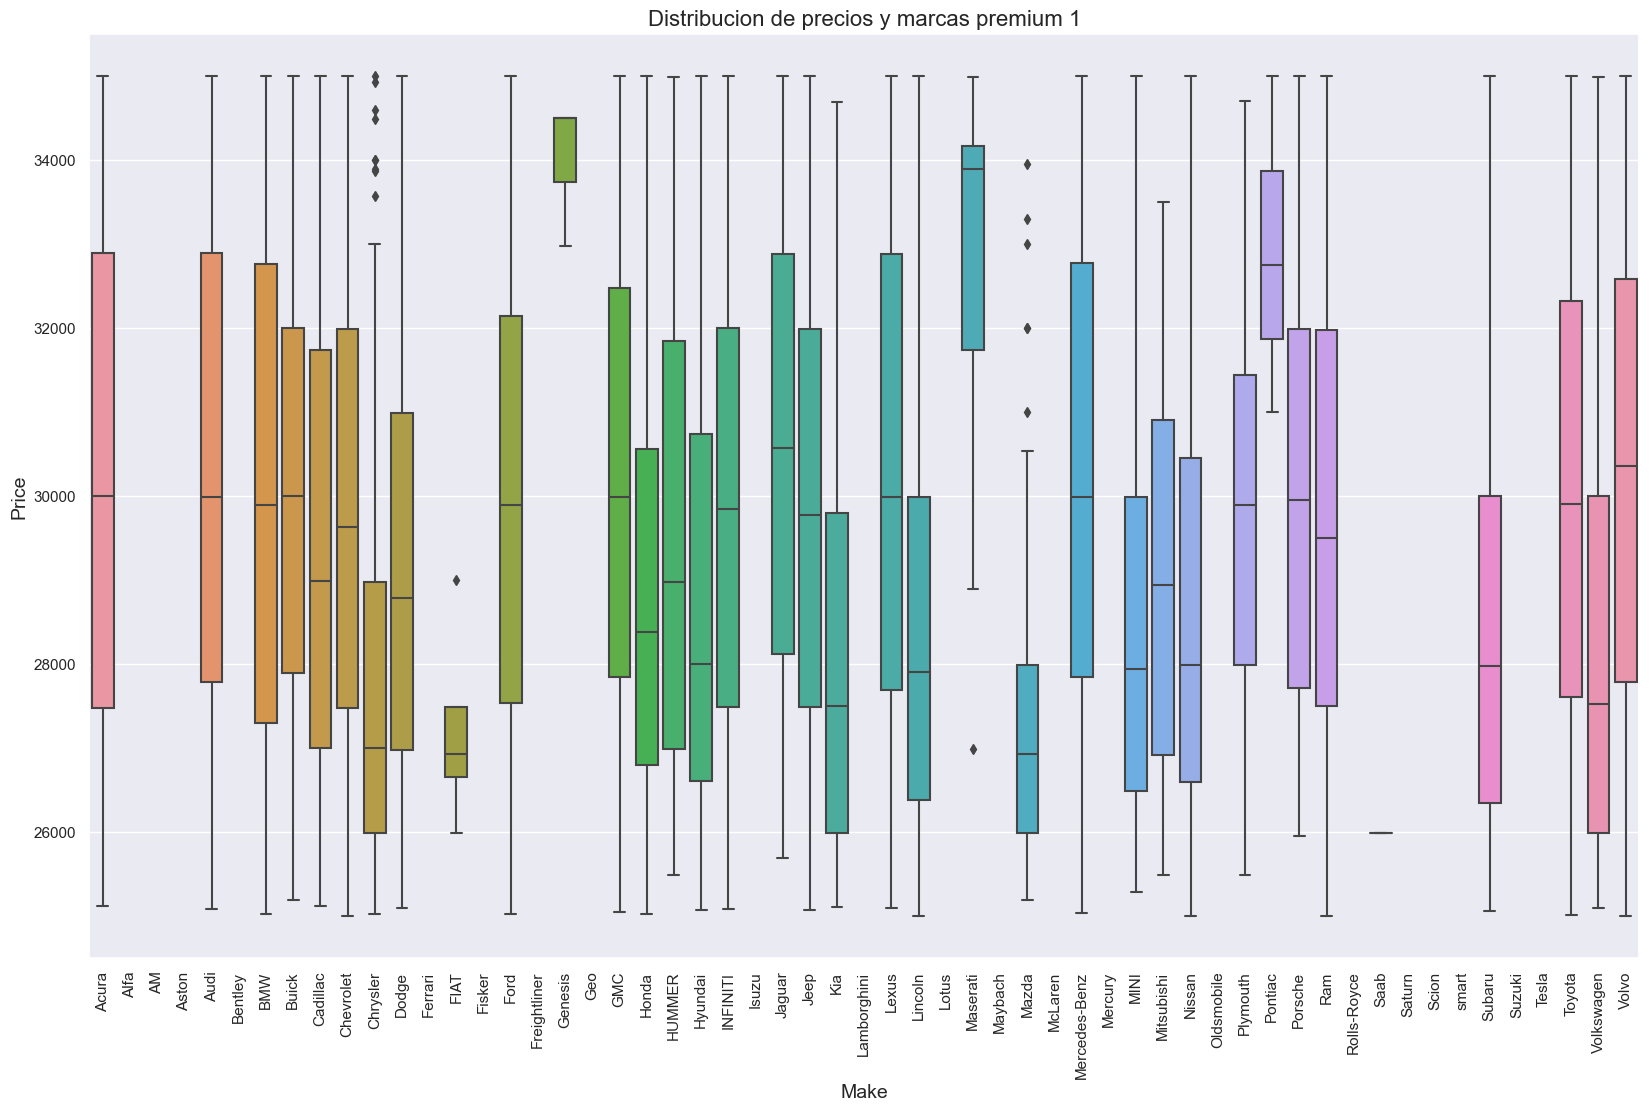

In [37]:
fx.boxplot_graph(df_test['Make'], df_test_premium1['Price'], 'Distribucion de precios y Segmento premium 1')

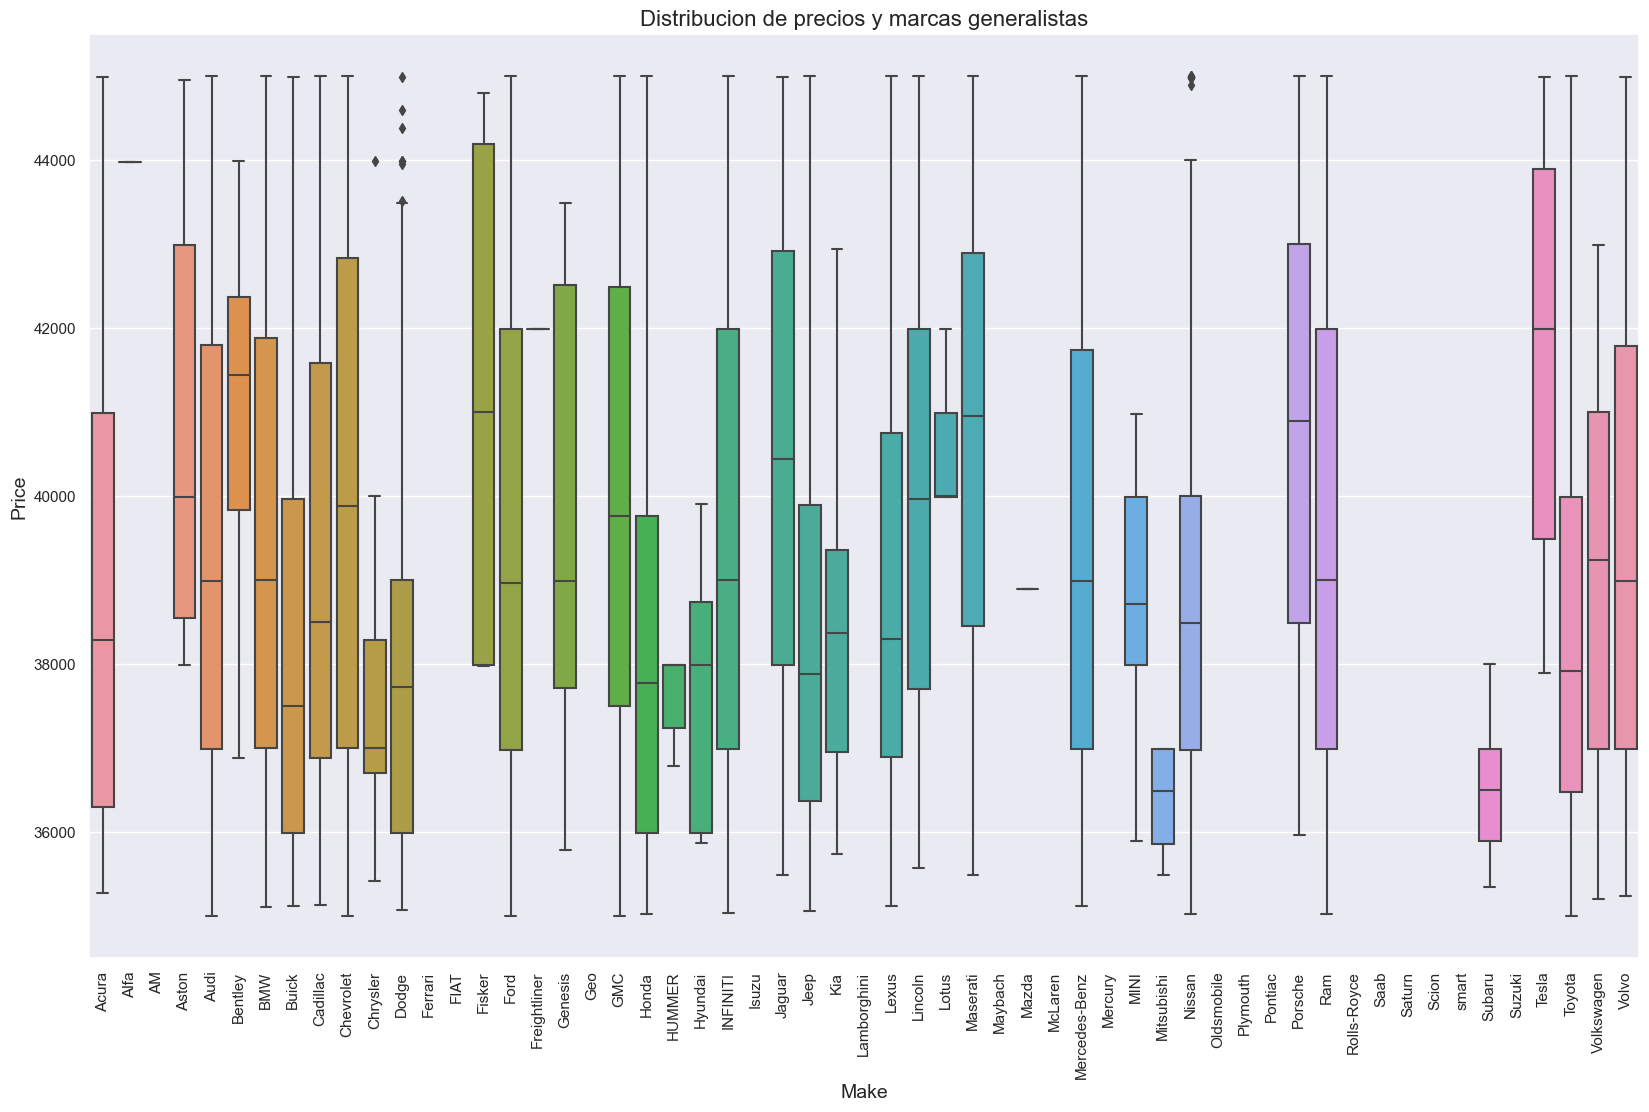

In [11]:
fx.boxplot_graph(df_test['Make'], df_test_premium2['Price'], 'Distribucion de precios y Segmento premium 2')

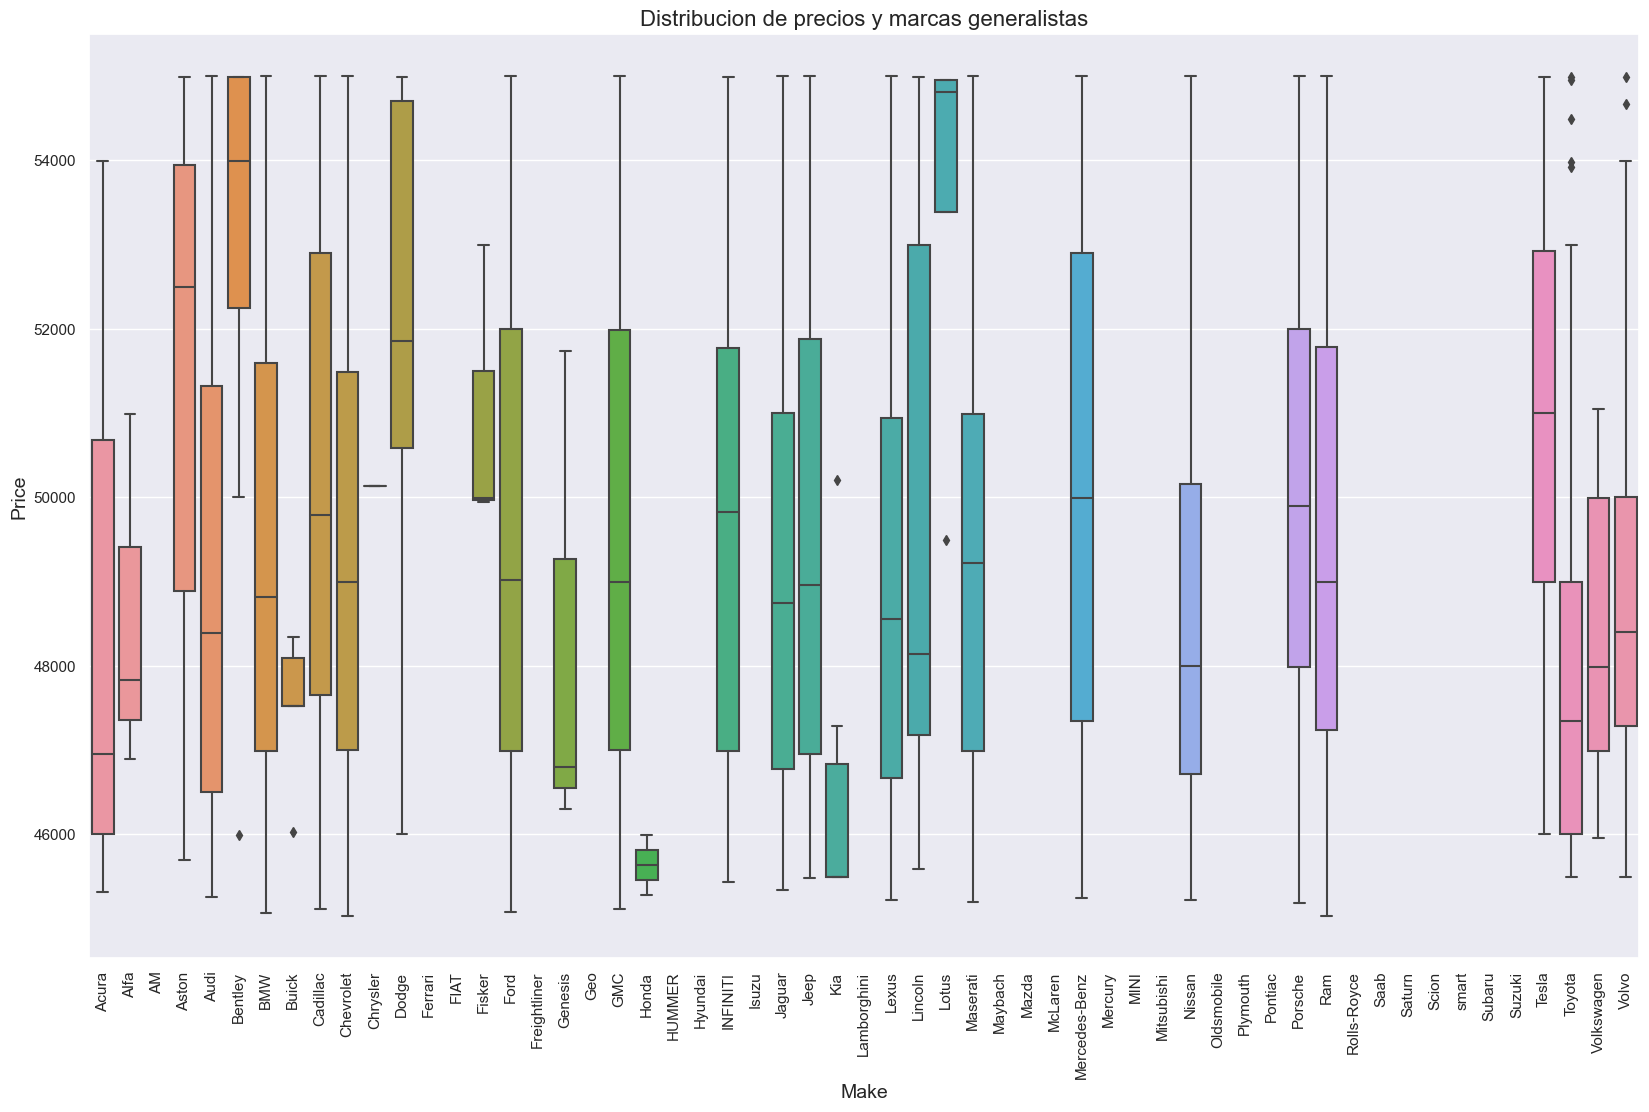

In [12]:
fx.boxplot_graph(df_test['Make'], df_test_premium3['Price'], 'Distribucion de precios y Segmento premium 3')

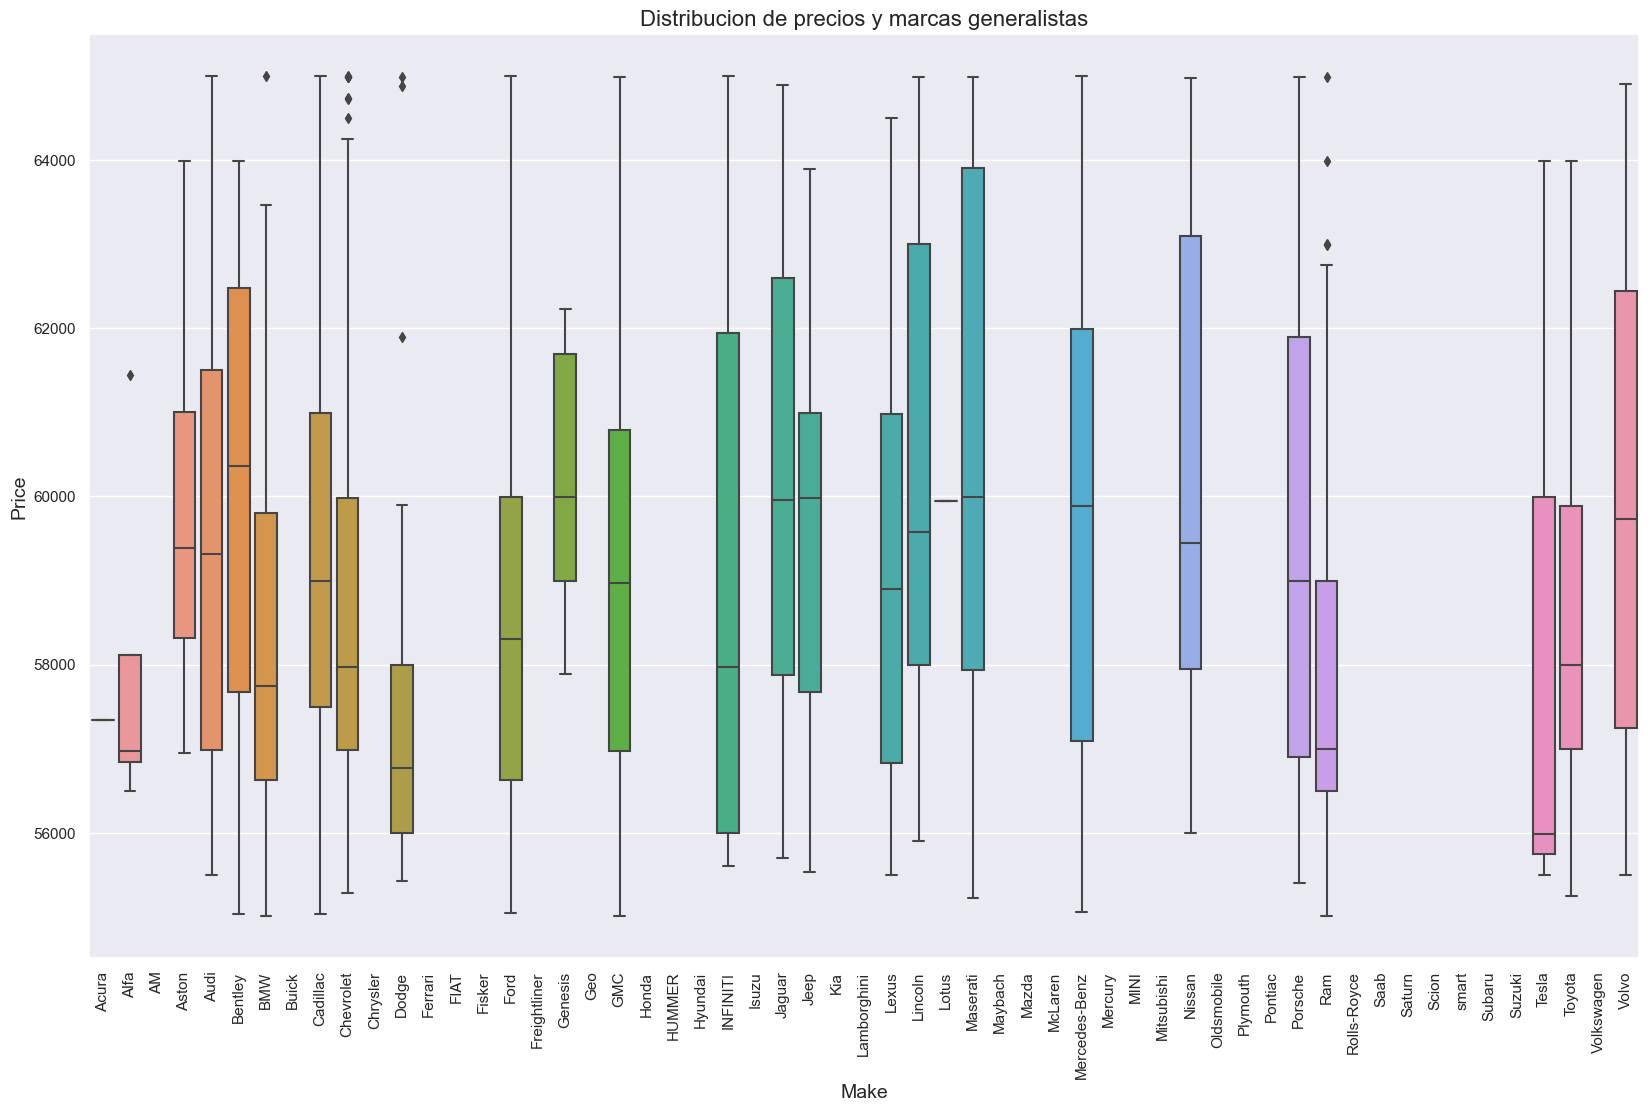

In [13]:
fx.boxplot_graph(df_test['Make'], df_test_premium4['Price'], 'Distribucion de precios y Segmento premium 4')

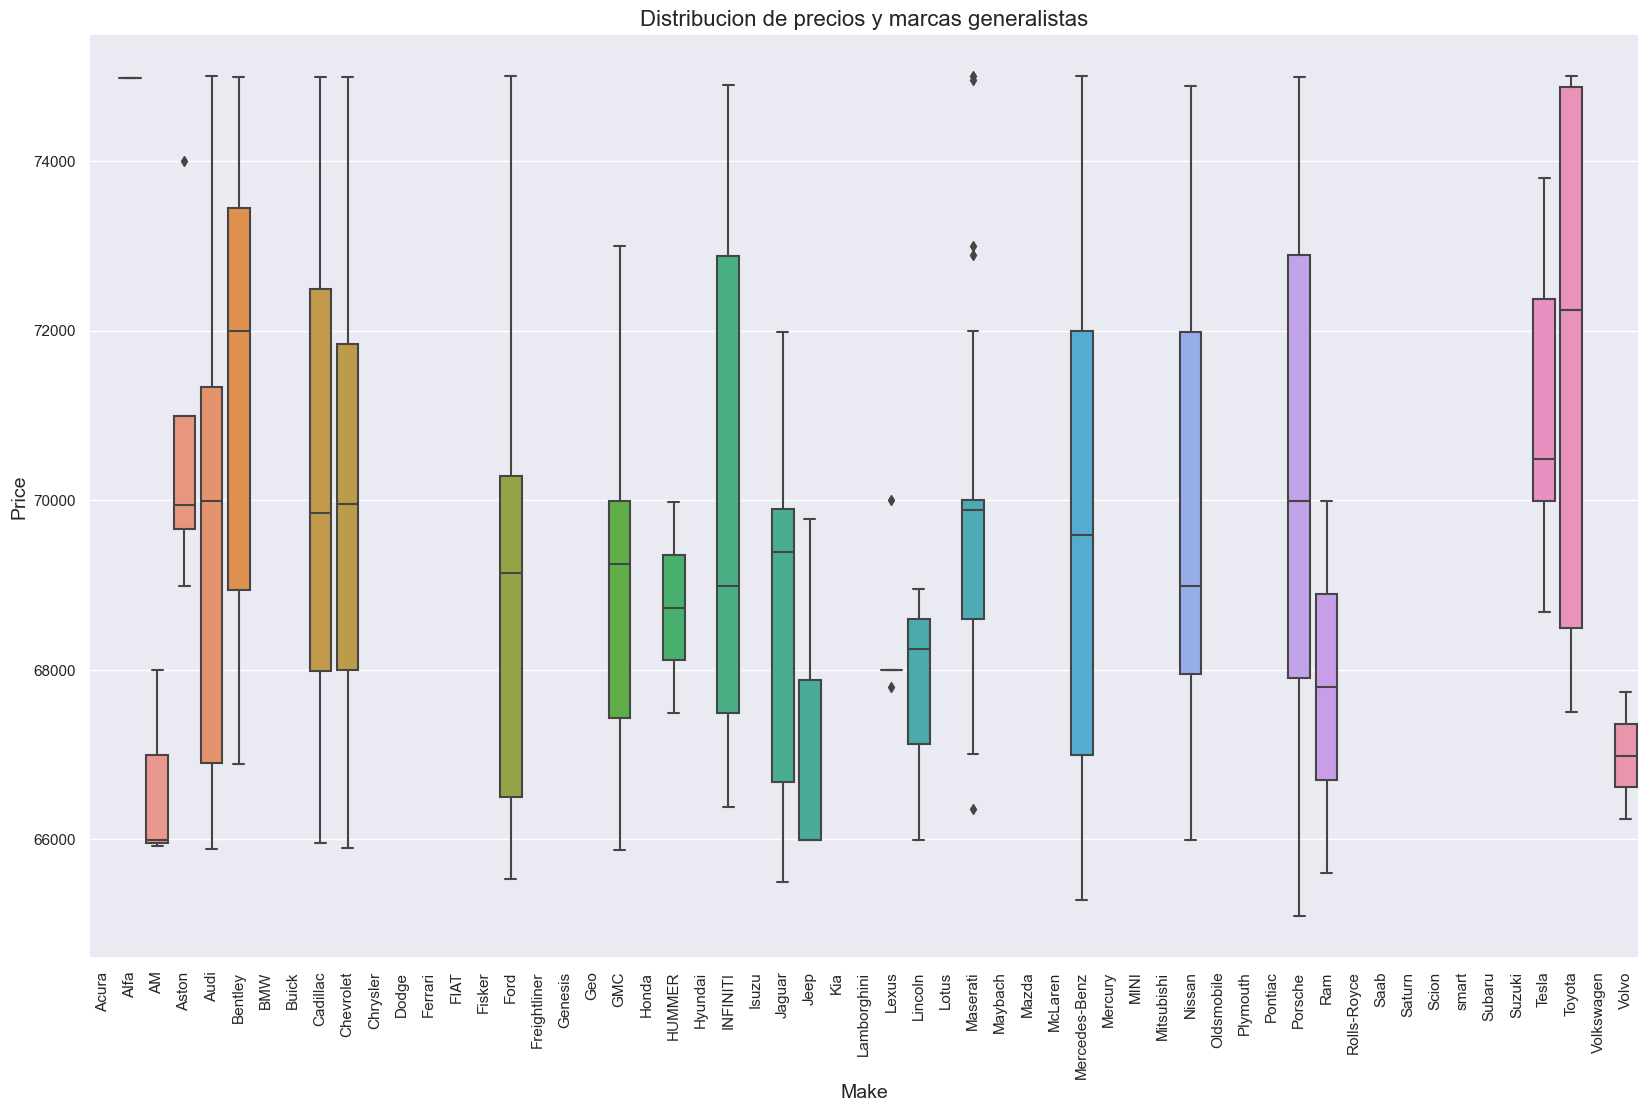

In [14]:
fx.boxplot_graph(df_test['Make'], df_test_premium5['Price'], 'Distribucion de precios y segmento premium 5')

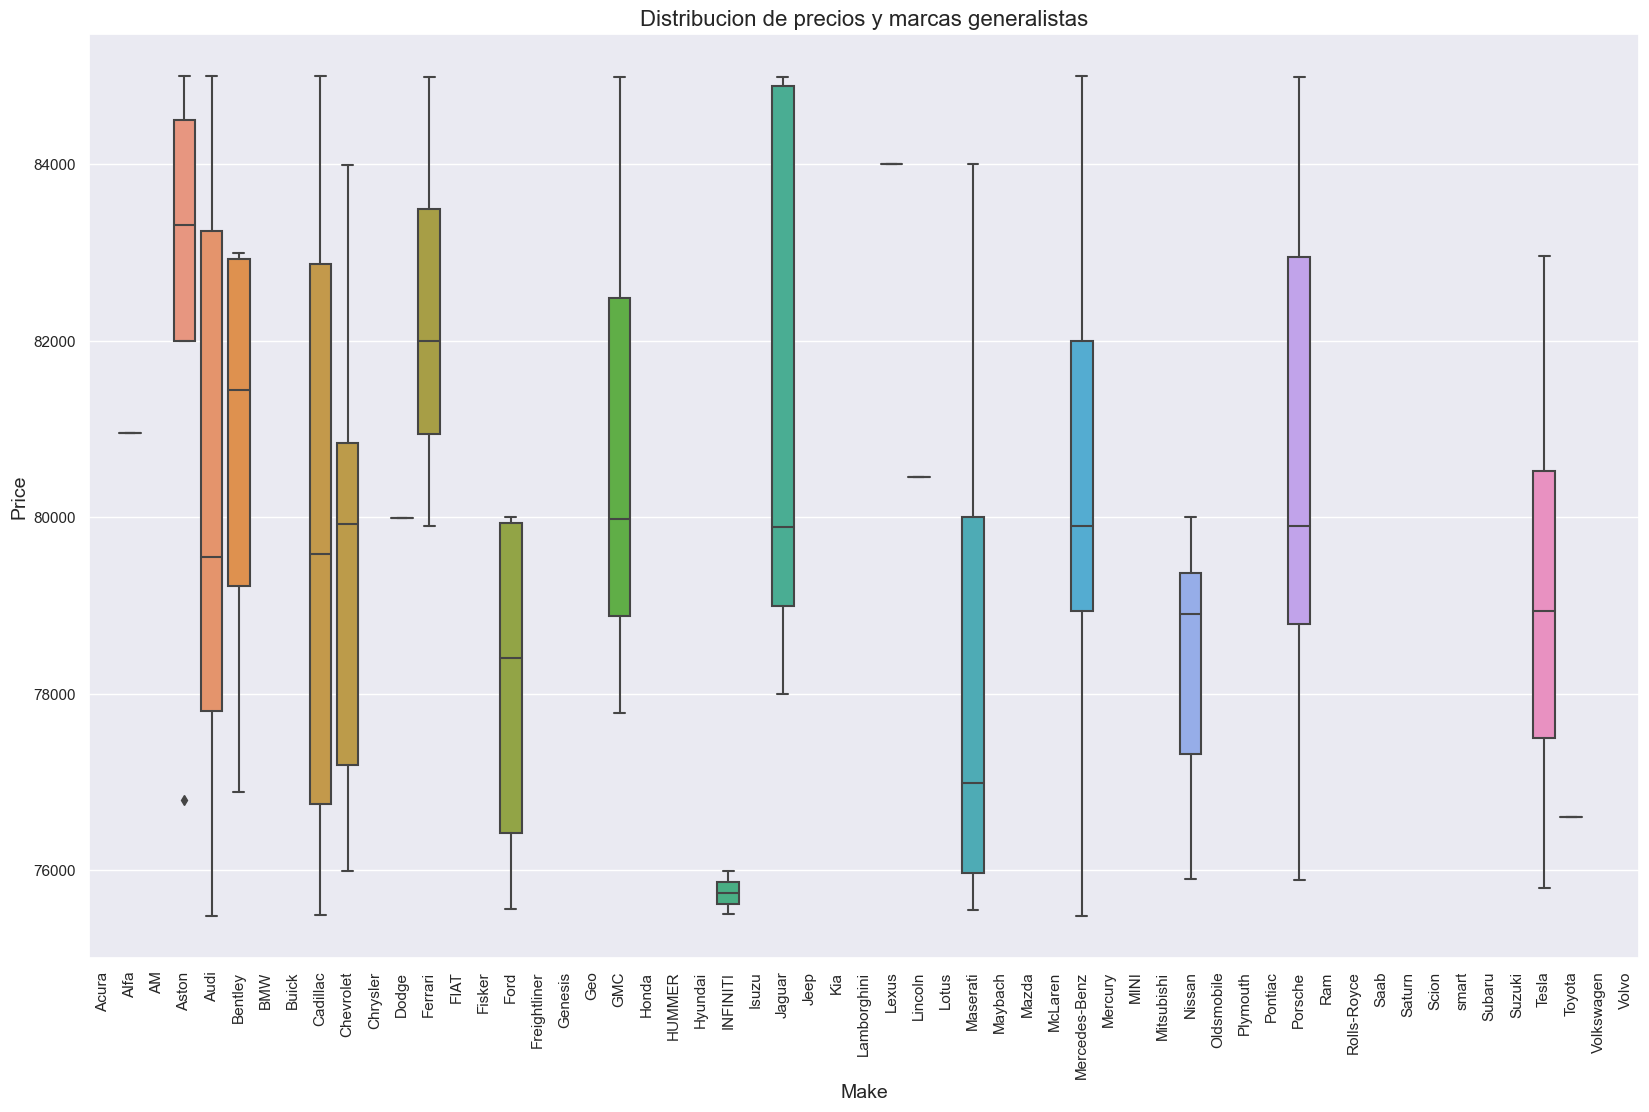

In [15]:
fx.boxplot_graph(df_test['Make'], df_test_premium6['Price'], 'Distribucion de precios y Segmento premium 6')

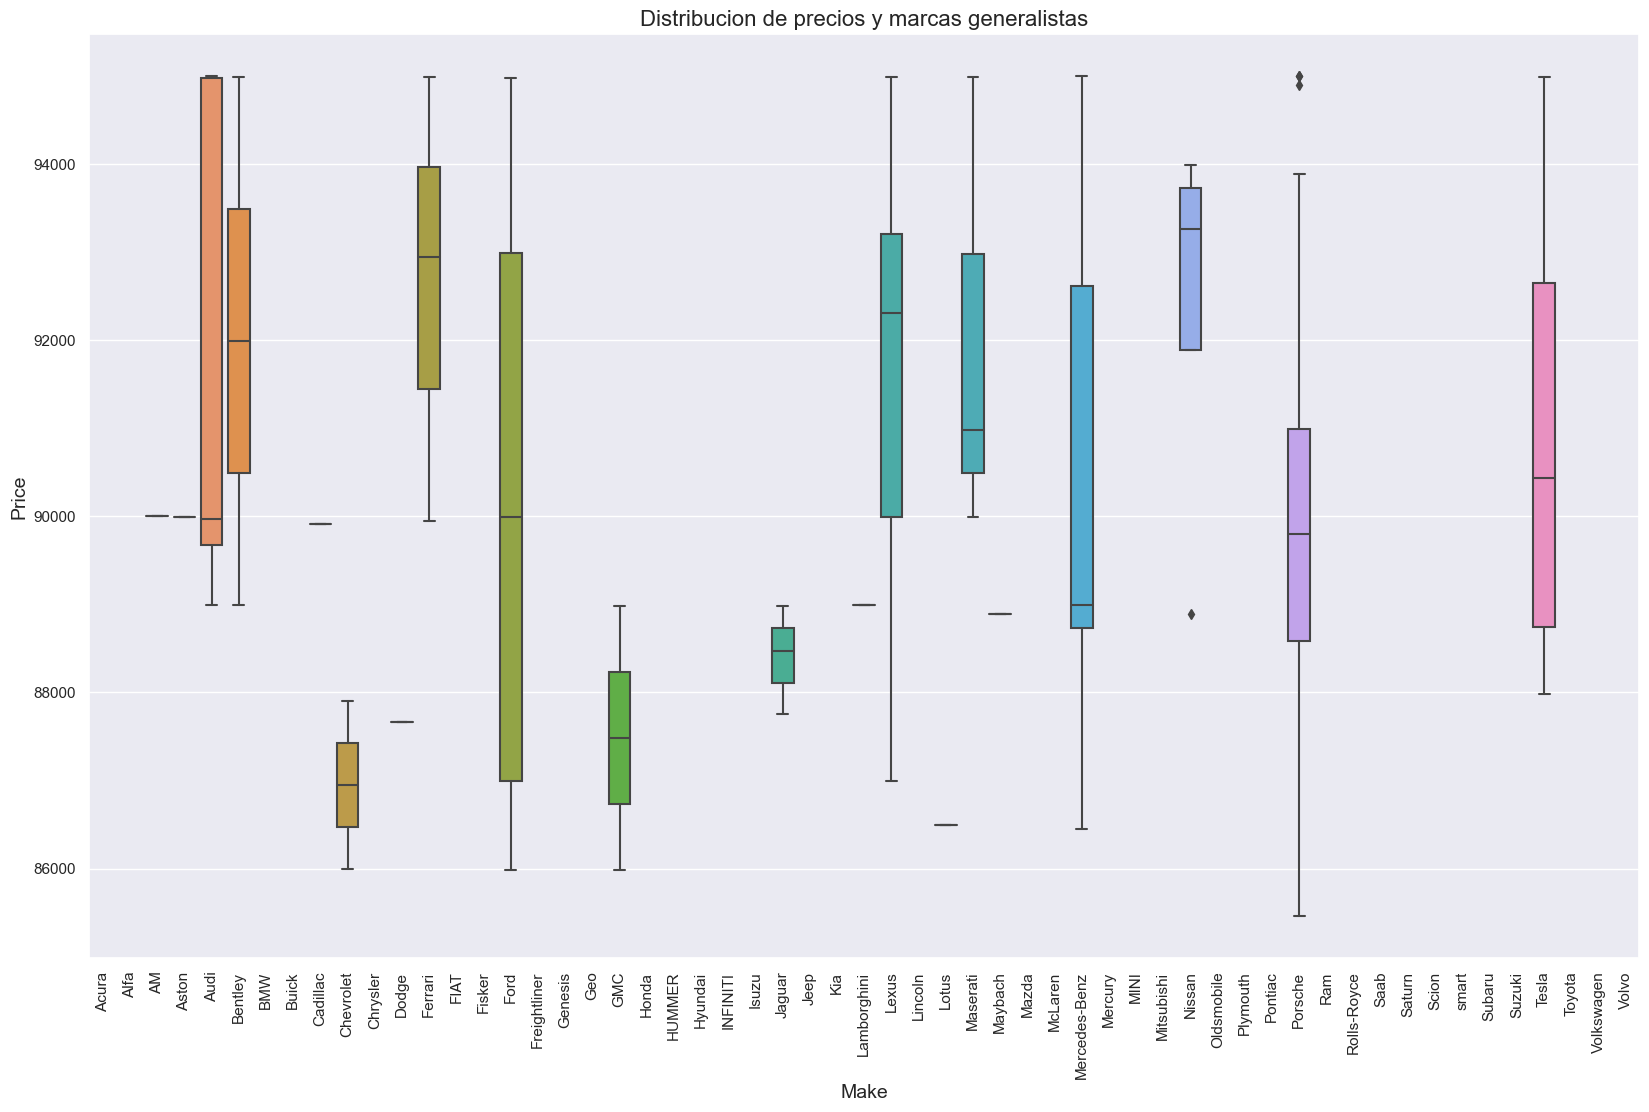

In [16]:
fx.boxplot_graph(df_test['Make'], df_test_premium7['Price'], 'Distribucion de precios y Segmento premium 7')

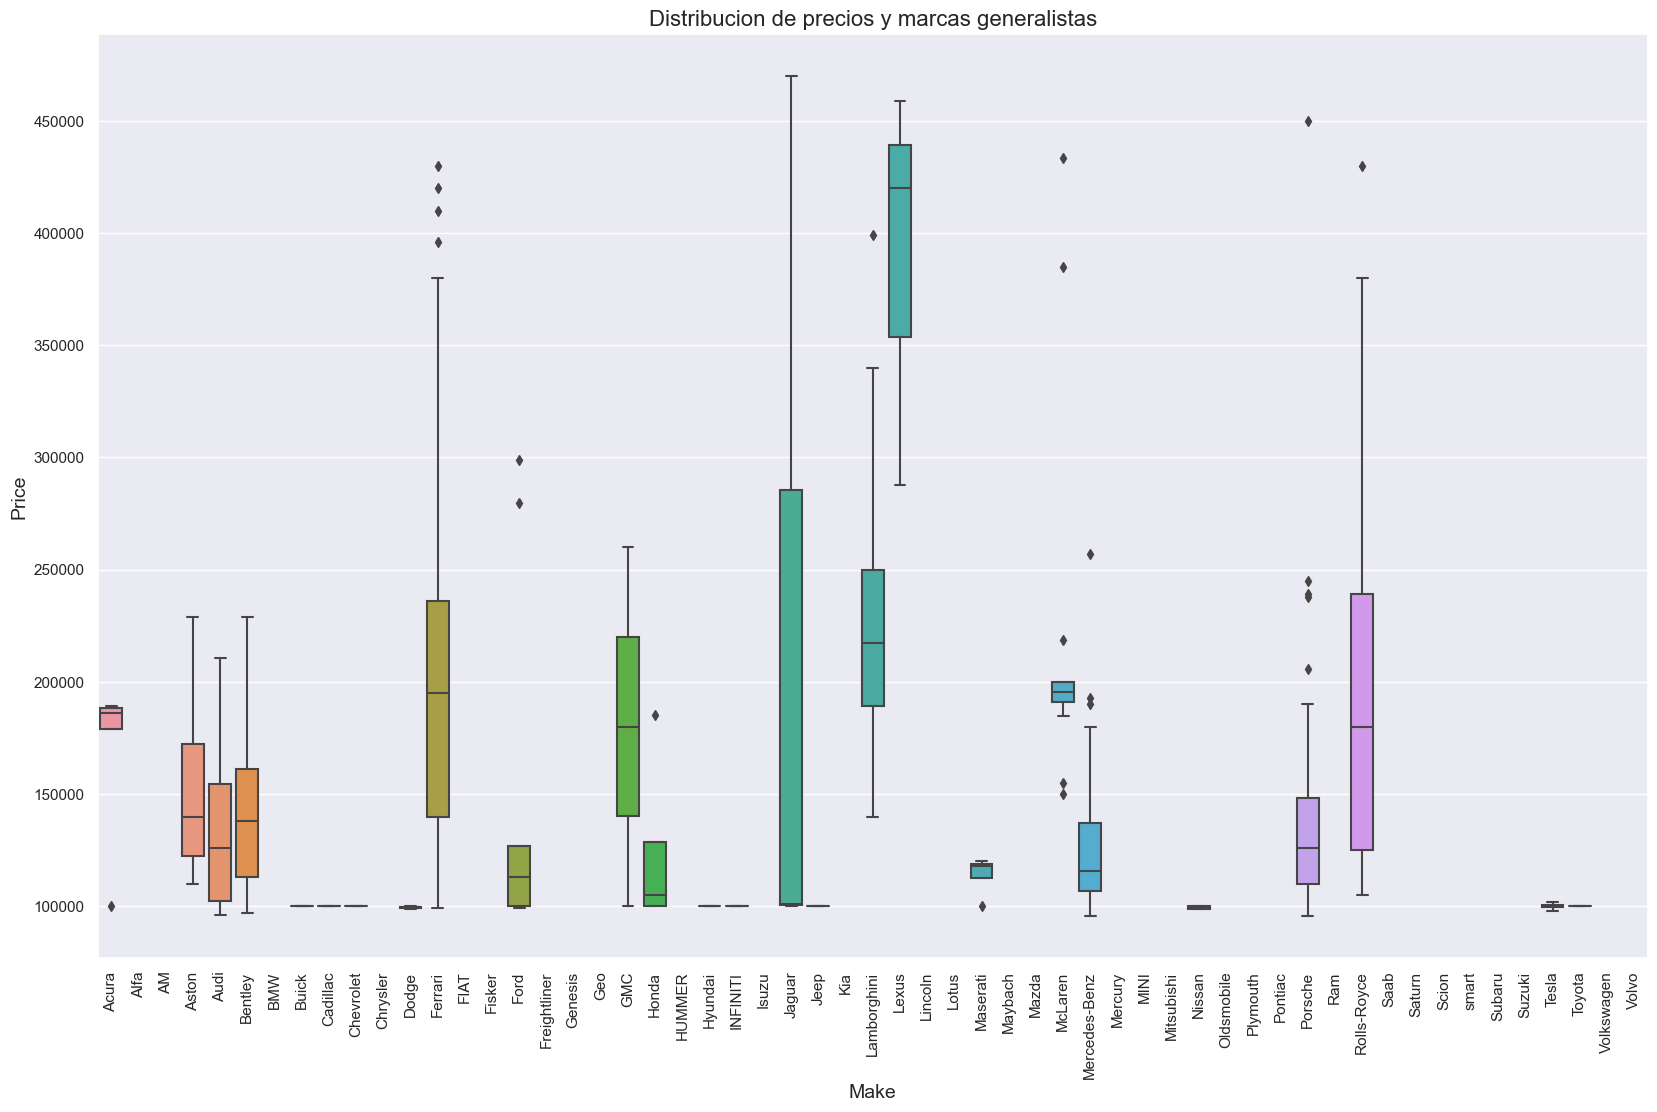

In [17]:
fx.boxplot_graph(df_test['Make'], df_test_premium8['Price'], 'Distribucion de precios y Segmento premium 8')

Los precios que estan fuera de la distribución normal se eliminaran del dataset
Método de puntuación Z para eliminar valores atípicos

In [18]:
#df_test_generalista_clean = fx.remove_outlier(df_test_generalista, 'Price', 1.5)
#df_test_generalista_clean.shape

In [19]:
#dividir dataset segun gama('generalista, premium, super-premium')

df_train_generalista = df_train[df_train.Gama == 'generalista']
df_train_generalista = df_train_generalista.select_dtypes(include='number')

df_train_premium1 = df_train[df_train.Gama == 'premium_1']
df_train_premium1 = df_train_premium1.select_dtypes(include='number')

df_train_premium2 = df_train[df_train.Gama == 'premium_2']
df_train_premium2 = df_train_premium2.select_dtypes(include='number')

df_train_premium3 = df_train[df_train.Gama == 'premium_3']
df_train_premium3 = df_train_premium3.select_dtypes(include='number')

df_train_premium4 = df_train[df_train.Gama == 'premium_4']
df_train_premium4 = df_train_premium4.select_dtypes(include='number')

df_train_premium5 = df_train[df_train.Gama == 'premium_5']
df_train_premium5 = df_train_premium5.select_dtypes(include='number')

df_train_premium6 = df_train[df_train.Gama == 'premium_6']
df_train_premium6 = df_train_premium6.select_dtypes(include='number')

df_train_premium7 = df_train[df_train.Gama == 'premium_7']
df_train_premium7 = df_train_premium7.select_dtypes(include='number')

df_train_premium8 = df_train[df_train.Gama == 'premium_8']
df_train_premium8 = df_train_premium8.select_dtypes(include='number')

In [20]:
# Entrenamiento para segmento generalista bajo modelo DecisionTreeRegresor
 
X_train_model = df_train_generalista.drop(columns = ['Price'])
y_train_model = df_train_generalista['Price']

clf_dt = DecisionTreeRegressor().fit(X_train_model, y_train_model)

X_test_model = df_test_generalista.drop(columns = ['Price'])
y_test_model = df_test_generalista['Price']

y_hat_dt = clf_dt.predict(X_test_model)
print(f'''Reporte para DecisionTreeRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para DecisionTreeRegressor
RMSE: 5648.191606138848
MAE: 3700.0
R2 Score: -0.1725937282023693


In [21]:
# Entrenamiento para segmento premium 1 bajo modelo DecisionTreeRegresor

X_train_model = df_train_premium1.drop(columns = ['Price'])
y_train_model = df_train_premium1['Price']

clf_dt = DecisionTreeRegressor().fit(X_train_model, y_train_model)

X_test_model = df_test_premium1.drop(columns = ['Price'])
y_test_model = df_test_premium1['Price']

y_hat_dt = clf_dt.predict(X_test_model)
print(f'''Reporte para DecisionTreeRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para DecisionTreeRegressor
RMSE: 4509.320114618484
MAE: 3343.0
R2 Score: -1.5445330585012789


In [22]:
# Entrenamiento para segmento premium 2 bajo modelo DecisionTreeRegresor

X_train_model = df_train_premium2.drop(columns = ['Price'])
y_train_model = df_train_premium2['Price']

clf_dt = DecisionTreeRegressor().fit(X_train_model, y_train_model)

X_test_model = df_test_premium2.drop(columns = ['Price'])
y_test_model = df_test_premium2['Price']

y_hat_dt = clf_dt.predict(X_test_model)
print(f'''Reporte para DecisionTreeRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para DecisionTreeRegressor
RMSE: 4420.262048760942
MAE: 3015.0
R2 Score: -1.4337601719202984


In [23]:
# Entrenamiento para segmento premium 3 bajo modelo DecisionTreeRegresor

X_train_model = df_train_premium3.drop(columns = ['Price'])
y_train_model = df_train_premium3['Price']

clf_dt = DecisionTreeRegressor().fit(X_train_model, y_train_model)


X_test_model = df_test_premium3.drop(columns = ['Price'])
y_test_model = df_test_premium3['Price']

y_hat_dt = clf_dt.predict(X_test_model)
print(f'''Reporte para DecisionTreeRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para DecisionTreeRegressor
RMSE: 4476.659764957018
MAE: 3142.0
R2 Score: -1.4801417813953002


In [24]:
# Entrenamiento para segmento premium 4 bajo modelo DecisionTreeRegresor

X_train_model = df_train_premium4.drop(columns = ['Price'])
y_train_model = df_train_premium4['Price']

clf_dt = DecisionTreeRegressor().fit(X_train_model, y_train_model)


X_test_model = df_test_premium4.drop(columns = ['Price'])
y_test_model = df_test_premium4['Price']

y_hat_dt = clf_dt.predict(X_test_model)
print(f'''Reporte para DecisionTreeRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para DecisionTreeRegressor
RMSE: 4050.416197138443
MAE: 2613.0
R2 Score: -1.3058741329265828


In [25]:
# Entrenamiento para segmento premium 5 bajo modelo DecisionTreeRegresor


X_train_model = df_train_premium5.drop(columns = ['Price'])
y_train_model = df_train_premium5['Price']

clf_dt = DecisionTreeRegressor().fit(X_train_model, y_train_model)


X_test_model = df_test_premium5.drop(columns = ['Price'])
y_test_model = df_test_premium5['Price']

y_hat_dt = clf_dt.predict(X_test_model)
print(f'''Reporte para DecisionTreeRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para DecisionTreeRegressor
RMSE: 4046.6830845293134
MAE: 2885.0
R2 Score: -1.1149967246209767


In [26]:
# Entrenamiento para segmento premium 6 bajo modelo DecisionTreeRegresor

X_train_model = df_train_premium6.drop(columns = ['Price'])
y_train_model = df_train_premium6['Price']

clf_dt = DecisionTreeRegressor().fit(X_train_model, y_train_model)

X_test_model = df_test_premium6.drop(columns = ['Price'])
y_test_model = df_test_premium6['Price']

y_hat_dt = clf_dt.predict(X_test_model)
print(f'''Reporte para DecisionTreeRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para DecisionTreeRegressor
RMSE: 4253.770193117613
MAE: 3017.5
R2 Score: -1.2926000458235687


In [27]:
# Entrenamiento para segmento premium 7 bajo modelo DecisionTreeRegresor

X_train_model = df_train_premium7.drop(columns = ['Price'])
y_train_model = df_train_premium7['Price']

clf_dt = DecisionTreeRegressor().fit(X_train_model, y_train_model)


X_test_model = df_test_premium7.drop(columns = ['Price'])
y_test_model = df_test_premium7['Price']

y_hat_dt = clf_dt.predict(X_test_model)
print(f'''Reporte para DecisionTreeRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para DecisionTreeRegressor
RMSE: 4531.410532788512
MAE: 3388.0
R2 Score: -1.9057767894027342


In [28]:
# Entrenamiento para segmento premium 8 bajo modelo DecisionTreeRegresor

X_train_model = df_train_premium8.drop(columns = ['Price'])
y_train_model = df_train_premium8['Price']

clf_dt = DecisionTreeRegressor().fit(X_train_model, y_train_model)


X_test_model = df_test_premium8.drop(columns = ['Price'])
y_test_model = df_test_premium8['Price']

y_hat_dt = clf_dt.predict(X_test_model)
print(f'''Reporte para DecisionTreeRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para DecisionTreeRegressor
RMSE: 80008.49479467109
MAE: 29521.0
R2 Score: -0.38051453961772386


In [29]:
# Entrenamiento para segmento generalista bajo modelo LinearRegression

X_train_model = df_train_generalista.drop(columns = ['Price'])
y_train_model = df_train_generalista['Price']

clf_lr = LinearRegression().fit(X_train_model, y_train_model)

X_test_model = df_test_generalista.drop(columns = ['Price'])
y_test_model = df_test_generalista['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LinearRegression
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')


Reporte para LinearRegression
RMSE: 3448.757785407445
MAE: 2278.447394916322
R2 Score: 0.5628262140901543


In [30]:
# Entrenamiento para segmento generalista bajo modelo RandomForestRegressor

X_train_model = df_train_generalista.drop(columns = ['Price'])
y_train_model = df_train_generalista['Price']

clf_lr = RandomForestRegressor().fit(X_train_model, y_train_model)

X_test_model = df_test_generalista.drop(columns = ['Price'])
y_test_model = df_test_generalista['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para RandomForestRegressor
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para RandomForestRegressor
RMSE: 4407.489944275986
MAE: 2701.8099999999995
R2 Score: 0.28597834213108153


In [31]:
# Entrenamiento para segmento generalista bajo modelo LogisticRegression

X_train_model = df_train_premium5.drop(columns = ['Price'])
y_train_model = df_train_premium5['Price']

clf_lr = LogisticRegression().fit(X_train_model, y_train_model)

X_test_model = df_test_premium5.drop(columns = ['Price'])
y_test_model = df_test_premium5['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LogisticRegression
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

/Users/jorge/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Reporte para LogisticRegression
RMSE: 2787.869658929851
MAE: 2132.0
R2 Score: -0.0038209189749935923


In [32]:
# Entrenamiento para segmento generalista bajo modelo LassoCV

X_train_model = df_train_generalista.drop(columns = ['Price'])
y_train_model = df_train_generalista['Price']

clf_lr = LassoCV(cv=3).fit(X_train_model, y_train_model)

X_test_model = df_test_generalista.drop(columns = ['Price'])
y_test_model = df_test_generalista['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LassoCV
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para LassoCV
RMSE: 3870.0422998785434
MAE: 2575.8492727487446
R2 Score: 0.44949641862029865


In [33]:
# Entrenamiento para segmento premium 1 bajo modelo LassoCV

X_train_model = df_train_premium1.drop(columns = ['Price'])
y_train_model = df_train_premium1['Price']

clf_lr = LassoCV(cv=3).fit(X_train_model, y_train_model)

X_test_model = df_test_premium1.drop(columns = ['Price'])
y_test_model = df_test_premium1['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LassoCV
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para LassoCV
RMSE: 2756.3468958113303
MAE: 2269.385124545388
R2 Score: 0.0492776309327444


In [34]:
# # Entrenamiento para segmento premium 2 bajo modelo LassoCV

X_train_model = df_train_premium2.drop(columns = ['Price'])
y_train_model = df_train_premium2['Price']

clf_lr = LassoCV(cv=3).fit(X_train_model, y_train_model)

X_test_model = df_test_premium2.drop(columns = ['Price'])
y_test_model = df_test_premium2['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LassoCV
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para LassoCV
RMSE: 2817.6280277769265
MAE: 2447.4489296098545
R2 Score: 0.011107543922172058


In [39]:
# # Entrenamiento para segmento premium 3 bajo modelo LassoCV

X_train_model = df_train_premium3.drop(columns = ['Price'])
y_train_model = df_train_premium3['Price']

clf_lr = LassoCV(cv=3).fit(X_train_model, y_train_model)

X_test_model = df_test_premium3.drop(columns = ['Price'])
y_test_model = df_test_premium3['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LassoCV
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para LassoCV
RMSE: 2842.6014400961008
MAE: 2441.7016836310067
R2 Score: -6.340131804005722e-07


In [40]:
# # Entrenamiento para segmento premium 4 bajo modelo LassoCV

X_train_model = df_train_premium4.drop(columns = ['Price'])
y_train_model = df_train_premium4['Price']

clf_lr = LassoCV(cv=3).fit(X_train_model, y_train_model)

X_test_model = df_test_premium4.drop(columns = ['Price'])
y_test_model = df_test_premium4['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LassoCV
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para LassoCV
RMSE: 2673.2523658470914
MAE: 1954.3775579185167
R2 Score: -0.004421996426354324


In [41]:
# # Entrenamiento para segmento premium 5 bajo modelo LassoCV

X_train_model = df_train_premium5.drop(columns = ['Price'])
y_train_model = df_train_premium5['Price']

clf_lr = LassoCV(cv=3).fit(X_train_model, y_train_model)

X_test_model = df_test_premium5.drop(columns = ['Price'])
y_test_model = df_test_premium5['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LassoCV
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para LassoCV
RMSE: 2772.7403219803527
MAE: 2191.8952263134997
R2 Score: 0.0070446792280676185


In [42]:
# # Entrenamiento para segmento premium 6 bajo modelo LassoCV

X_train_model = df_train_premium6.drop(columns = ['Price'])
y_train_model = df_train_premium6['Price']

clf_lr = LassoCV(cv=3).fit(X_train_model, y_train_model)

X_test_model = df_test_premium6.drop(columns = ['Price'])
y_test_model = df_test_premium6['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LassoCV
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para LassoCV
RMSE: 2841.149125471068
MAE: 2315.7309811608648
R2 Score: -0.022747221100465786


In [44]:
# # Entrenamiento para segmento premium 7 bajo modelo LassoCV

X_train_model = df_train_premium7.drop(columns = ['Price'])
y_train_model = df_train_premium7['Price']

clf_lr = LassoCV(cv=3).fit(X_train_model, y_train_model)

X_test_model = df_test_premium7.drop(columns = ['Price'])
y_test_model = df_test_premium7['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LassoCV
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para LassoCV
RMSE: 2653.8916641892065
MAE: 1721.5712473230014
R2 Score: 0.0033060742477457605


In [45]:
# # Entrenamiento para segmento premium 8 bajo modelo LassoCV

X_train_model = df_train_premium8.drop(columns = ['Price'])
y_train_model = df_train_premium8['Price']

clf_lr = LassoCV(cv=3).fit(X_train_model, y_train_model)

X_test_model = df_test_premium8.drop(columns = ['Price'])
y_test_model = df_test_premium8['Price']

y_hat_dt = clf_lr.predict(X_test_model)
print(f'''Reporte para LassoCV
RMSE: {np.sqrt(mean_squared_error(y_test_model, y_hat_dt))}
MAE: {median_absolute_error(y_test_model, y_hat_dt)}
R2 Score: {r2_score(y_test_model, y_hat_dt)}''')

Reporte para LassoCV
RMSE: 68060.67916548147
MAE: 42149.01270262373
R2 Score: 0.0010095376508378884
